# AutoML: Data Science Made Really Easy

In [2]:
import pandas as pd
import featuretools as ft
from sklearn.preprocessing import Imputer
from sklearn.pipeline import Pipeline
from hpsklearn import HyperoptEstimator, any_classifier
import numpy as np
from collections import defaultdict
import seaborn as sns
import pickle

%matplotlib inline

WARN: OMP_NUM_THREADS=None =>
... If you are using openblas if you are using openblas set OMP_NUM_THREADS=1 or risk subprocess calls hanging indefinitely


## Who Am I?


- Data Science grad from UBC
- Work a company called Imbellus


## What I Every Media Outlet Thinks We Do

![https://www.arl.army.mil/www/default.cfm?article=3179](./images/Machine-Learning.jpg)


In [203]:
train_df = pd.read_csv("data/train.csv")
train_df["Pclass"] = train_df["Pclass"].astype("category")
train_df['CabinClass'] = train_df["Cabin"].str.get(0)
train_df['LastName'] = train_df['Name'].str.split(", ").apply(lambda x: x[0])
train_df['Honorific'] = train_df['Name'].str.extract(" ([a-zA-z]+)")
train_df['TicketPrefix'] = train_df['Ticket'].str.extract("(.+) ")
train_df['TicketNumber'] = train_df['Ticket'].str.extract("([0-9]+)$").astype(float)
train_df.sample(5)

/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  """
/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  
/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  import sys


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,CabinClass,LastName,Honorific,TicketPrefix,TicketNumber
313,314,0,3,"Hendekovic, Mr. Ignjac",male,28.0,0,0,349243,7.8958,NaN,S,NaN,Hendekovic,Mr,NaN,349243.0
327,328,1,2,"Ball, Mrs. (Ada E Hall)",female,36.0,0,0,28551,13.0000,D,S,D,Ball,Mrs,NaN,28551.0
252,253,0,1,"Stead, Mr. William Thomas",male,62.0,0,0,113514,26.5500,C87,S,C,Stead,Mr,NaN,113514.0
818,819,0,3,"Holm, Mr. John Fredrik Alexander",male,43.0,0,0,C 7075,6.4500,NaN,S,NaN,Holm,Mr,C,7075.0
218,219,1,1,"Bazzani, Miss. Albina",female,32.0,0,0,11813,76.2917,D15,C,D,Bazzani,Miss,NaN,11813.0


In [204]:
train_df = train_df.drop(columns=["Name", "Cabin", "Ticket"])
train_features = train_df.drop(columns=["Survived"])
train_target = train_df["Survived"]

In [205]:
train_features.sample(5)

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,CabinClass,LastName,Honorific,TicketPrefix,TicketNumber
271,272,3,male,25.0,0,0,0.0000,S,NaN,Tornquist,Mr,NaN,NaN
458,459,2,female,50.0,0,0,10.5000,S,NaN,Toomey,Miss,F.C.C.,13531.0
766,767,1,male,NaN,0,0,39.6000,C,NaN,Brewe,Dr,NaN,112379.0
6,7,1,male,54.0,0,0,51.8625,S,E,McCarthy,Mr,NaN,17463.0
105,106,3,male,28.0,0,0,7.8958,S,NaN,Mionoff,Mr,NaN,349207.0


In [207]:
es = ft.EntitySet(id="titanic")
es.entity_from_dataframe(entity_id="titanic",
                         dataframe=train_features,
                         index="PassengerId",
                         variable_types={
                             "Pclass": ft.variable_types.Categorical,
                             "Sex": ft.variable_types.Categorical,
                             "Embarked": ft.variable_types.Categorical,
                             "CabinClass": ft.variable_types.Categorical,
                             "LastName": ft.variable_types.Categorical,
                             "Honorific": ft.variable_types.Categorical,
                             "TicketPrefix": ft.variable_types.Categorical
                           })
es.normalize_entity(base_entity_id="titanic",
                new_entity_id="classes",
                index="Pclass")
es.normalize_entity(base_entity_id="titanic",
                new_entity_id="sexes",
                index="Sex")
es.normalize_entity(base_entity_id="titanic",
                new_entity_id="embarkeds",
                index="Embarked")
es.normalize_entity(base_entity_id="titanic",
                new_entity_id="cabinclasses",
                index="CabinClass")
es.normalize_entity(base_entity_id="titanic",
                new_entity_id="honorfics",
                index="Honorific")
es.normalize_entity(base_entity_id="titanic",
                new_entity_id="lastnames",
                index="LastName")
es.normalize_entity(base_entity_id="titanic",
                new_entity_id="ticketprefixes",
                index="TicketPrefix")

Entityset: titanic
  Entities:
    titanic (shape = [891, 13])
    classes (shape = [3, 1])
    sexes (shape = [2, 1])
    embarkeds (shape = [4, 1])
    cabinclasses (shape = [9, 1])
    ...And 3 more
  Relationships:
    titanic.Pclass -> classes.Pclass
    titanic.Sex -> sexes.Sex
    titanic.Embarked -> embarkeds.Embarked
    titanic.CabinClass -> cabinclasses.CabinClass
    titanic.Honorific -> honorfics.Honorific
    ...and 2 more

In [208]:
feature_matrix, features = ft.dfs(entityset=es,
                              target_entity="titanic",
                              save_progress="results/",
                              verbose=True)

feature_matrix, features = ft.encode_features(feature_matrix, features)

Built 313 features
Elapsed: 00:16 | Remaining: 00:00 | Progress: 100%|██████████|| Calculated: 1/1 cutoff times


In [209]:
imputer = Imputer(strategy='median')
imputed_matrix = imputer.fit_transform(feature_matrix)

In [210]:
model = "kitchen-sink"
name = f"100_{model}_titanic_dfs_fe"

estim = HyperoptEstimator(classifier=any_classifier(model),
                          max_evals=100,
                          trial_timeout=60,
                          fit_increment_dump_filename=f"results/models/{name}.pickle",
                          verbose=0,
                          seed=42
                          )

estim.fit(imputed_matrix,
          train_target,
          n_folds=5,    
          random_state=41,
          )

train_loss = estim.trials.best_trial["result"]["loss"]

print(train_loss)
print(estim.best_model())

with open(f"results/models/{train_loss:.3}_{name}_estimator.pickle", "wb+") as estimator:
    pickle.dump(estim, estimator)

/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter

0.1571268237934904
{'learner': GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.005168273904849856, loss='deviance',
              max_depth=None, max_features=0.11598886784560192,
              max_leaf_nodes=None, min_impurity_decrease=0.0,
              min_impurity_split=None, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=156, presort='auto', random_state=4,
              subsample=0.6081704543206994, verbose=0, warm_start=False), 'preprocs': (MinMaxScaler(copy=True, feature_range=(-1.0, 1.0)),), 'ex_preprocs': ()}


In [211]:
trial_results = defaultdict(list)
for trial in range(0, 100):
    if 'loss' in estim.trials.trials[trial]['result']:
        trial_results['loss'].append(estim.trials.trials[trial]['result']['loss'])
        trial_results['loss_variance'].append(estim.trials.trials[0]['result']['loss_variance'])
    else:
        print(estim.trials.trials[trial]['result'])
        trial_results['loss'].append(None)
        trial_results['loss_variance'].append(None)
    for key, value in estim.trials.trials[trial]['misc']['idxs'].items():
        if value and "kitchen-sink." in key:
            trial_results['algorithm_type'].append(key.split(".")[1])
            break

{'status': 'fail', 'failure': 'TimeOut'}
{'status': 'fail', 'failure': 'TimeOut'}
{'status': 'fail', 'failure': 'TimeOut'}
{'status': 'fail', 'failure': 'TimeOut'}
{'status': 'fail', 'failure': 'TimeOut'}
{'status': 'fail', 'failure': 'TimeOut'}
{'status': 'fail', 'failure': 'TimeOut'}
{'status': 'fail', 'failure': 'TimeOut'}
{'status': 'fail', 'failure': 'TimeOut'}
{'status': 'fail', 'failure': 'TimeOut'}
{'status': 'fail', 'failure': 'TimeOut'}
{'status': 'fail', 'failure': 'TimeOut'}
{'status': 'fail', 'failure': 'TimeOut'}
{'status': 'fail', 'failure': 'TimeOut'}
{'status': 'fail', 'failure': 'TimeOut'}
{'status': 'fail', 'failure': 'TimeOut'}
{'status': 'fail', 'failure': 'TimeOut'}
{'status': 'fail', 'failure': 'TimeOut'}


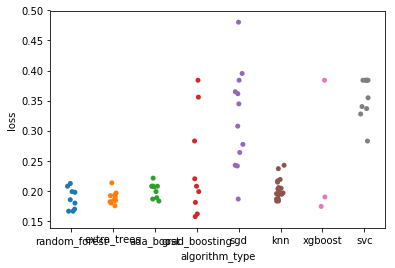

In [212]:
trial_df = pd.DataFrame(trial_results)
sns.stripplot(data = trial_df, x='algorithm_type', y='loss', jitter=True)

In [64]:
for property, value in vars(features[40]).items():
    print(property, ": ", value)

parent_entity :  Entity: sexes
  Variables:
    Sex (dtype: index)
  Shape:
    (2, 1)
_variable_type :  <class 'featuretools.variable_types.variable.Numeric'>
entity_id :  titanic
entityset :  Entityset: titanic
  Entities:
    titanic (shape = [891, 8])
    classes (shape = [3, 1])
    sexes (shape = [2, 1])
    embarkeds (shape = [4, 1])
  Relationships:
    titanic.Pclass -> classes.Pclass
    titanic.Sex -> sexes.Sex
    titanic.Embarked -> embarkeds.Embarked
base_features :  [<Feature: STD(titanic.Age)>]
additional_attributes :  {}


In [75]:
features[40]

<Feature: sexes.STD(titanic.Age)>

In [94]:
train_df.groupby("Sex").agg([np.nanmean, np.nanstd, np.nanmin, np.nanmax])

PassengerId                            Survived                   \
           nanmean      nanstd nanmin nanmax   nanmean    nanstd nanmin   
Sex                                                                       
female  431.028662  256.437007      2    889  0.742038  0.437513      0   
male    454.147314  257.262918      1    891  0.188908  0.391436      0   

                 Pclass              ...     SibSp            Parch            \
       nanmax   nanmean    nanstd    ...    nanmin nanmax   nanmean    nanstd   
Sex                                  ...                                        
female      1  2.159236  0.855924    ...         0      8  0.649682  1.021216   
male        1  2.389948  0.812875    ...         0      8  0.235702  0.611763   

                           Fare                              
       nanmin nanmax    nanmean     nanstd nanmin    nanmax  
Sex                                                          
female      0      6  44.479818  57.905271   6.75  512.3292  
male        0      5  25.523893  43.100865   0.00  512.3292  

[2 rows x 28 columns]

## Testing

In [214]:
test_df = pd.read_csv("data/test.csv")
test_df["Pclass"] = test_df["Pclass"].astype("category")

In [215]:
test_df['CabinClass'] = test_df["Cabin"].str.get(0)
test_df['LastName'] = test_df['Name'].str.split(", ").apply(lambda x: x[0])
test_df['Honorific'] = test_df['Name'].str.extract(" ([a-zA-z]+)")
test_df['TicketPrefix'] = test_df['Ticket'].str.extract("(.+) ")
test_df['TicketNumber'] = test_df['Ticket'].str.extract("([0-9]+)$").astype(float)
test_df = test_df.drop(columns=["Name", "Cabin", "Ticket"])

/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  This is separate from the ipykernel package so we can avoid doing imports until
/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  after removing the cwd from sys.path.
/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  """


In [216]:
ft.save_features(features, "results/encoded_features.pkl")

In [217]:
es = ft.EntitySet(id="titanic")
es.entity_from_dataframe(entity_id="titanic",
                         dataframe=test_df,
                         index="PassengerId",
                         variable_types={
                             "Pclass": ft.variable_types.Categorical,
                             "Sex": ft.variable_types.Categorical,
                             "Embarked": ft.variable_types.Categorical})
es.normalize_entity(base_entity_id="titanic",
                new_entity_id="classes",
                index="Pclass")
es.normalize_entity(base_entity_id="titanic",
                new_entity_id="sexes",
                index="Sex")
es.normalize_entity(base_entity_id="titanic",
                new_entity_id="embarkeds",
                index="Embarked")
es.normalize_entity(base_entity_id="titanic",
                new_entity_id="cabinclasses",
                index="CabinClass")
es.normalize_entity(base_entity_id="titanic",
                new_entity_id="honorfics",
                index="Honorific")
es.normalize_entity(base_entity_id="titanic",
                new_entity_id="lastnames",
                index="LastName")
es.normalize_entity(base_entity_id="titanic",
                new_entity_id="ticketprefixes",
                index="TicketPrefix")

test_features = ft.load_features("results/encoded_features.pkl", es)

In [218]:
test_matrix = ft.calculate_feature_matrix(test_features)

In [219]:
test_matrix = imputer.transform(test_matrix)

In [220]:
submission_df = pd.DataFrame({'PassengerId': test_df['PassengerId'],
              'Survived': estim.predict(test_matrix)})

In [222]:
submission_df.to_csv("results/ft_hpsklearn_submission_fe.csv", index=False)

## More Features

In [227]:
trial_df['algorithm_type'].unique()

array(['random_forest', 'extra_trees', 'ada_boost', 'grad_boosting',
       'sgd', 'knn', 'xgboost', 'svc'], dtype=object)

In [ ]:
class FeaturetoolsTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self, categorical_features, index, filepath, warm_start):
        self.categorical_features = categorical_features
        self.index = index
        self.filepath = filepath
        self.warm_start = warm_start
        
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        variable_types = {variable: ft.variable_types.Categorical for variable in self.categorical_features}
        es = ft.EntitySet(id="id")
        es.entity_from_dataframe(entity_id="id",
                                 dataframe=X,
                                 index=self.index,
                                 variable_types=variable_types)
        for variable in self.categorical_features:
            es.normalize_entity(base_entity_id="id",
                            new_entity_id=variable,
                            index=variable)
        self.es = es
        if self.warm_start:
            self.features = ft.load_features(self.filepath, self.es)
            matrix = ft.calculate_feature_matrix(self.features)
            return matrix
        else:
            matrix, self.features = ft.dfs(entityset=self.es,
                                      target_entity="id",
                                      save_progress="results/",
                                      verbose=False)
            
            matrix, self.features = ft.encode_features(matrix, self.features)
            self.warm_start = True
            ft.save_features(self.features, self.filepath)
            return matrix

In [ ]:
from hpsklearn import *

model_list = (sgd,
              knn,
              random_forest,
              xgboost_classification,
              extra_trees,
              ada_boost,
              gradient_boosting)

for model in model_list:
    name = f"100_{model.__name__}_titanic_dfs_ensemble_pipeline"

    estim = HyperoptEstimator(classifier=any_classifier(model.__name__),
                              max_evals=100,
                              trial_timeout=3600,
                              fit_increment_dump_filename=f"results/models/{name}.pickle",
                              verbose=0,
                              seed=42
                              )

    estim.fit(imputed_matrix,
              train_target,
              n_folds=5,    
              random_state=41,
              )

    train_loss = estim.trials.best_trial["result"]["loss"]

    print(train_loss)
    print(estim.best_model())

    with open(f"results/models/{train_loss:.3}_{name}_estimator.pickle", "wb+") as estimator:
        pickle.dump(estim, estimator)

/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter

0.16273849607182944
{'learner': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features=0.08791673396919308,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=69, n_jobs=1, oob_score=False, random_state=2,
            verbose=False, warm_start=False), 'preprocs': (StandardScaler(copy=True, with_mean=False, with_std=False),), 'ex_preprocs': ()}


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter

0.1571268237934904
{'learner': GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.005168273904849856, loss='deviance',
              max_depth=None, max_features=0.11598886784560192,
              max_leaf_nodes=None, min_impurity_decrease=0.0,
              min_impurity_split=None, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=156, presort='auto', random_state=4,
              subsample=0.6081704543206994, verbose=0, warm_start=False), 'preprocs': (MinMaxScaler(copy=True, feature_range=(-1.0, 1.0)),), 'ex_preprocs': ()}


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter

0.16273849607182944
{'learner': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features=0.08791673396919308,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=69, n_jobs=1, oob_score=False, random_state=2,
            verbose=False, warm_start=False), 'preprocs': (StandardScaler(copy=True, with_mean=False, with_std=False),), 'ex_preprocs': ()}


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter

0.16273849607182944
{'learner': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features=0.08791673396919308,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=69, n_jobs=1, oob_score=False, random_state=2,
            verbose=False, warm_start=False), 'preprocs': (StandardScaler(copy=True, with_mean=False, with_std=False),), 'ex_preprocs': ()}


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter

0.1571268237934904
{'learner': GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.005168273904849856, loss='deviance',
              max_depth=None, max_features=0.11598886784560192,
              max_leaf_nodes=None, min_impurity_decrease=0.0,
              min_impurity_split=None, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=156, presort='auto', random_state=4,
              subsample=0.6081704543206994, verbose=0, warm_start=False), 'preprocs': (MinMaxScaler(copy=True, feature_range=(-1.0, 1.0)),), 'ex_preprocs': ()}


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter

0.1571268237934904
{'learner': GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.005168273904849856, loss='deviance',
              max_depth=None, max_features=0.11598886784560192,
              max_leaf_nodes=None, min_impurity_decrease=0.0,
              min_impurity_split=None, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=156, presort='auto', random_state=4,
              subsample=0.6081704543206994, verbose=0, warm_start=False), 'preprocs': (MinMaxScaler(copy=True, feature_range=(-1.0, 1.0)),), 'ex_preprocs': ()}


/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter